## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists to test the performance of an old website page compared to a newly developed website page using bootstrapping for hypothesis testing.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Load data into the DataFrame
df = pd.read_csv('ab_data.csv')

# Top few rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> **Note :** As, number of non-null count in each column = 0, the rows **do not** have missing values

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. So, **Remove** the rows that are not aligned up and store it in new dataframe **df2**

In [8]:
# Remove rows where, 1. treatment not aligned with new_page  &   2. control not aligned with old_page
# Selecting rows that lined up, storing in df2
treatment_index = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
control_index = df[((df['group'] == 'control') == (df['landing_page'] == 'old_page')) == False]
index_value = (treatment_index + control_index).index
df.drop(index_value, inplace=True)
df2 = df

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

b. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

c. Duplicate **user_id** in **df2**

In [12]:
user_id_dup = df2[df2.duplicated('user_id')].user_id.reset_index(drop=True)[0]
user_id_dup

773192

d. Row information for the repeat **user_id**? 

In [13]:
df2.query('user_id == @user_id_dup')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


e. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# Remove First row of the duplicate
df2.drop_duplicates('user_id', keep='last', ignore_index=True, inplace=True)

In [15]:
df2.query('user_id == @user_id_dup')

,user_id,timestamp,group,landing_page,converted
2861,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Statistics after cleaning

a. The probability of an individual converting regardless of the page they receive

In [16]:
total_convert_mean = df2.converted.mean()
total_convert_mean

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_convert_mean = df2.query('group == "control"').converted.mean()
control_convert_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_convert_mean = df2.query('group == "treatment"').converted.mean()
treatment_convert_mean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

**Observation :** 
- The probability that an individual receiving the new page & old page is almost equal, where additional manipulation is not required to balance the uneven weightings of pages
- Based on observation of control converted mean & treatment converted mean, there is **no sufficient evidence** to say that the new treatment page leads to more conversions, as control converted mean is **greater** than treatment converted mean.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  

Stating hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null ($H_0$) & Alternative ($H_1$) Hypothesis**
$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

a. **Convert rate** for $p_{new}$ under the null

In [20]:
# As there is no difference in conversion based on the page, which means the conversions for each page are the same.
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. **Convert rate** for $p_{old}$ under the null

In [21]:
# As there is no difference in conversion based on the page, which means the conversions for each page are the same.
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [22]:
# As there is no difference in conversion based on the page, which means the conversions for each page are the same.
p_new - p_old

0.0

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
(new_page_converted.mean() - old_page_converted.mean())

-0.000924431894692615

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [29]:
# convert into numpy array
p_diffs = np.array(p_diffs)

# obsolute difference
obs_diff = treatment_convert_mean - control_convert_mean

i. Plot a histogram of the **p_diffs**.

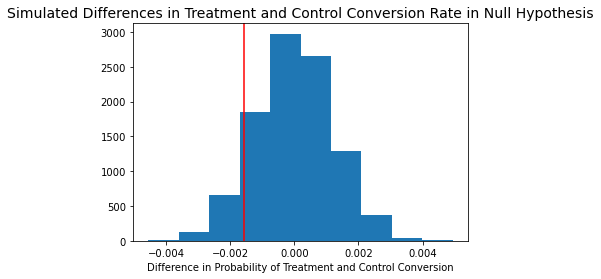

In [30]:
plt.hist(p_diffs);
plt.xlabel('Difference in Probability of Treatment and Control Conversion')
plt.title('Simulated Differences in Treatment and Control Conversion Rate in Null Hypothesis', fontsize=14)
plt.axvline(obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
(p_diffs > obs_diff).mean()

0.9011

**Result :** 
> - The **p-value** is **0.9011**, which is far more greater than typical Type I error rate of 5% ($\alpha$ = 0.05) in scientific studies. 
> - Hence, **we would fail to reject the null** 
> - And conclude that there is **no sufficient evidence** to say that the new page is better than old page.

k. Using **Statsmodel**

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

l. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

**Result :**
> - The p-value is **0.905** which is nearly equal to the p-value observed from bootstrapped hypothesis testing and greater than Type I error rate of 5% ( 𝛼  = 0.05)
> - Hence, **we would fail to reject the Null hypothesis**
> - The z-score of **-1.31** indicates that the data is lesser than the mean by **1.31** standard deviation.

<a id='regression'></a>
### Part III - A regression approach

`1.` Since each row is either a conversion or no conversion, in this case we would be performing **Logistics regression**

a. Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# Create an intercept column
df2['intercept'] = 1

# Create a dummy variable 'ab_page' for which page each user received, 1-treatment & 0-control
df2[['control','ab_page']] = pd.get_dummies(df2.group)

# Drop the control column
df2.drop('control', axis=1, inplace=True)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


b. Instantiate and fit the model

In [35]:
# Instantiate the model
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

# Fit the model
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


c. Summary of the model

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:02:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**Result :**
> - The p-value in regression model is **0.190**, which indicates that the treatment page is not statistically significant at (𝛼  = 0.05) to the response variable.
> - This value is different from Part II, as the null hypothesis here is that, **the coefficient is equal to zero and to understand whether there is a statistical relationship between converted and the receiving page.**
>   > - **Part II : One sided**
$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

**As the situation is vastly more complex like,**
> - Users have different characteristics: Different ages, genders,etc.,
> - Users spend different amounts of time on the website
> - Users may be from different regions
> - Users may find the website from different sources, etc.,

it is always a good idea to consider other factors rather than only control Vs treatment group, to add into regression model.

**Disadvantage :** **Multicollinearity**. As the regression model is highly reliance on a proper presentation of the data, all the additional terms **must be independent variables**.

### Adding additional country variable to the model
Additional data based on country is available. We will be adding the country data to main dataset and create a new dataframe **df_new** to predict whether there is an interaction between country and the conversion rates of the two pages.

In [37]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [38]:
# unique values in country and their counts
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


Instantiate and fit the model for country and conversion rate

In [40]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','CA','UK']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               1.521e-05
Time:                        16:12:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Result :**
> - The p-value of the countries are above $\alpha$ = 0.05. Hence, **none of the countries on its own are statistically significant** to the conversion rates of the two pages.

We would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [41]:
# Necessary interaction variables
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [42]:
# Instantiate the model
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','CA','UK','CA_page','UK_page']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               3.482e-05
Time:                        16:13:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Result :**
> - Again, we could see that the p-value of all the variables are above $\alpha$ = 0.05. Hence, there is **not sufficient evidence to suggest that there is an interaction between country and page received** that will predict whether a user converts or not.

### Let's check whether the timestamp had an impact on conversion,

In [43]:
# convert the datatype for  timestamp columns
df_new.timestamp = pd.to_datetime(df_new.timestamp)

# the start and end date in our dataset
print('Starting timestamp:', df_new.sort_values(by='timestamp').iloc[0].timestamp)
print('Ending timestamp:', df_new.sort_values(by='timestamp').iloc[-1].timestamp)

Starting timestamp: 2017-01-02 13:42:05.378582
Ending timestamp: 2017-01-24 13:41:54.460509


As the timestamp for our data is in the same month of **January**, let's categorize by the week

In [44]:
# adding week of the year and day of the week to our dataset based on timestamp value
df_new[['week','day']] = df_new.timestamp.dt.isocalendar()[['week','day']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_page,UK_page,week,day
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,2,6
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,4,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,3,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,3,7
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,3,1


In [45]:
# unique values and counts in week
df_new.week.value_counts()

2    92583
3    92293
1    84924
4    20784
Name: week, dtype: Int64

In [46]:
# unique values and counts in day
df_new.day.value_counts()

2    47148
1    45439
7    39915
6    39670
5    39626
3    39565
4    39221
Name: day, dtype: Int64

> **Note :** The test has been run only for 22 days based on the start and end timestamp

In [47]:
# creating necessary dummy vatiables
df_new[['week1','week2','week3','week4']] = pd.get_dummies(df_new.week)
df_new[['Mon','Tue','Wed','Thurs','Fri','Sat','Sun']] = pd.get_dummies(df_new.day)

#### Model based on week

In [48]:
# Instantiate the model for significant changed based on week
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','week1','week2','week3']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               1.675e-05
Time:                        16:18:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3124
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9726      0.021    -93.110      0.000      -2.014      -1.931
week1         -0.0328      0.024     -1.386      0.166      -0.079       0.014
week2         -0.0311      0.023     -1.322      0.186      -0.077       0.015
week3         -0.0133      0.023     -0.568      0.570      -0.059       0.033
==============================================================================
"""

**Result :**
> - The p-value of all the weeks are above $\alpha$ = 0.05. Hence, **none of the weeks on its own are statistically significant** to the conversion rates of the two pages.

#### Model based on day

In [49]:
# Instantiate the model for significant changed based on days
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','Mon','Tue','Wed','Thurs','Fri','Sat']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               2.601e-05
Time:                        16:19:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4773
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0069      0.015   -129.579      0.000      -2.037      -1.977
Mon            0.0254      0.021      1.200      0.230      -0.016       0.067
Tue            0.0101      0.021      0.482      0.630      -0.031       0.051
Wed            0.0177      0.022      0.807      0.420      -0.025       0.061
Thurs          0.0141      0.022      0.644      0.519      -0.029       0.057
Fri           -0.0172      0.022     -0.782      0.434      -0.060       0.026
Sat            0.0223      0.022      1.019      0.308      -0.021       0.065
==============================================================================
"""

**Result :**
> - The p-value of all the days of the week are above $\alpha$ = 0.05. Hence, **none of the days of the week on its own are statistically significant** to the conversion rates of the two pages.

We would now like to look at an interaction between page and week to see if there significant effects on conversion.

In [51]:
# Necessary interaction variables
df_new['week1_page'] = df_new['week1'] * df_new['ab_page']
df_new['week2_page'] = df_new['week2'] * df_new['ab_page']
df_new['week3_page'] = df_new['week3'] * df_new['ab_page']
df_new['week4_page'] = df_new['week4'] * df_new['ab_page']

In [52]:
# Instantiate the model for significant changed based on interaction of ab_page & week
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','week2','week3','week4','week2_page','week3_page','week4_page']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               2.482e-05
Time:                        16:22:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.6257
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9976      0.015   -133.327      0.000      -2.027      -1.968
ab_page       -0.0156      0.021     -0.736      0.462      -0.057       0.026
week2          0.0018      0.021      0.085      0.932      -0.039       0.042
week3          0.0185      0.021      0.896      0.370      -0.022       0.059
week4          0.0326      0.033      0.977      0.328      -0.033       0.098
week2_page  2.865e-05      0.029      0.001      0.999      -0.058       0.058
week3_page     0.0020      0.029      0.067      0.947      -0.055       0.059
week4_page     0.0004      0.047      0.008      0.993      -0.092       0.093
==============================================================================
"""

**Result :**
> - Again, we could see that the p-value of all the variables are above $\alpha$ = 0.05. Hence, there is **not sufficient evidence to suggest that there is an interaction between weeks and page received** that will predict whether a user converts or not.

We would now like to look at an interaction between page and day of the week to see if there significant effects on conversion.

In [53]:
# Necessary interaction variables for days & ab_page
df_new['Mon_page'] = df_new['Mon'] * df_new['ab_page']
df_new['Tue_page'] = df_new['Tue'] * df_new['ab_page']
df_new['Wed_page'] = df_new['Wed'] * df_new['ab_page']
df_new['Thurs_page'] = df_new['Thurs'] * df_new['ab_page']
df_new['Fri_page'] = df_new['Fri'] * df_new['ab_page']
df_new['Sat_page'] = df_new['Sat'] * df_new['ab_page']
df_new['Sun_page'] = df_new['Sun'] * df_new['ab_page']

##### Model for interaction between page and week days 

In [54]:
# Instantiate the model for significant changed based on interaction of ab_page & weekday
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','Mon','Tue','Wed','Thurs','Fri','Mon_page','Tue_page','Wed_page','Thurs_page','Fri_page']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290572
Method:                           MLE   Df Model:                           11
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               7.411e-05
Time:                        16:23:40   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1499
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9733      0.015   -129.017      0.000      -2.003      -1.943
ab_page       -0.0455      0.022     -2.083      0.037      -0.088      -0.003
Mon            0.0071      0.025      0.279      0.780      -0.043       0.057
Tue           -0.0503      0.025     -1.981      0.048      -0.100      -0.001
Wed           -0.0019      0.027     -0.071      0.944      -0.054       0.050
Thurs         -0.0029      0.027     -0.108      0.914      -0.055       0.049
Fri           -0.0592      0.027     -2.191      0.028      -0.112      -0.006
Mon_page       0.0145      0.036      0.402      0.687      -0.056       0.085
Tue_page       0.0986      0.036      2.753      0.006       0.028       0.169
Wed_page       0.0172      0.038      0.454      0.650      -0.057       0.091
Thurs_page     0.0122      0.038      0.320      0.749      -0.062       0.087
Fri_page       0.0621      0.038      1.626      0.104      -0.013       0.137
==============================================================================
"""

**Result :**
> - Among weekdays, only **Tuesday, Friday** and **interaction of tuesday and page received** has p-value below $\alpha$ = 0.05.

##### Model for interaction between page and week ends 

In [55]:
# Instantiate the model for significant changed based on interaction of ab_page & weekends
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','Sat','Sun','Sat_page','Sun_page']])

# Fit the model
results = log_mod.fit()

# summary of the model
results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:               3.195e-05
Time:                        16:25:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2362
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9947      0.009   -210.235      0.000      -2.013      -1.976
ab_page       -0.0035      0.013     -0.259      0.796      -0.030       0.023
Sat            0.0448      0.023      1.909      0.056      -0.001       0.091
Sun           -0.0023      0.024     -0.097      0.922      -0.049       0.044
Sat_page      -0.0673      0.034     -2.002      0.045      -0.133      -0.001
Sun_page      -0.0165      0.034     -0.489      0.625      -0.083       0.050
==============================================================================
"""

**Result :**
> - Among weekends, only **interaction of saturday and page received** has p-value below $\alpha$ = 0.05.

<a id='conclusions'></a>
## Conclusions

- An A/B test and regressions were conducted for an e-commerce webpage to understand if the conversion rate of new page is higher than the old page.
- **A/B test :** The null and alternative hypotheses were defined and the sampling dsitribution for the difference in conversion rate was simulated. 
    - Based on the computed p-value, **We failed to reject the null** and therefore the difference between the conversion rates of the two pages is not statistically significant.
- **Logistics regression model :** was also used to find out whether there's a statistical relationship between explanatory variables and conversion.    
| Response variable | Explanatory | Statistically significant? |
| --- | --- | --- |
| conversion | receiving webpage | NO |
| conversion | country | NO |
| conversion | week of the year | NO |
| conversion | day of the week | NO |
| conversion | interaction of country-receiving page | NO |
| conversion | interaction of week of the year-receiving page | NO |
| conversion | interaction of weekday-receiving page | only 1 in interaction |
| conversion | interaction of weekend-receiving page | only 1 in interaction |

    - Although, there is one value statistically significant in interactions of both weekdays and weekends, it may due to chance (not practically significant), as the remaining all other variables are far from the statistical significant category. 
    - These models do not fit in predicting the conversion, as there is no variable statistically significant and we need more data.
    - Overall, based on the available information, **we do not have sufficient evidence to suggest that the new page results in more conversions than the old page**.

**Note :** From the timestamp column, the total duration of time used to collect the data is nearly 22 days. This duration is not enough to make our A/B testing results reliable. More data need to be collected for a duration of at least 3 months in order to take into account the novelty effect and change aversion.

### Resources
- [Drop duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)
- [isocalendar()](https://stackoverflow.com/questions/2600775/how-to-get-week-number-in-python)
- [Drop based on index](https://stackoverflow.com/questions/14661701/how-to-drop-a-list-of-rows-from-pandas-dataframe)